### >>>INGESTA DE DATOS

In [60]:
import psycopg2
import pandas as pd

# Credenciales de la base de datos
dbname = "DBInmerso"
user = "postgres"
password = "postgres"
host = "localhost"  # Cambia esto según tu configuración
port = "5432"

# Crear la cadena de conexión
connection_string = f"dbname={dbname} user={user} password={password} host={host} port={port}"

# Intentar establecer la conexión
try:
    with psycopg2.connect(connection_string) as connection:
        # Consulta para concatenar las tablas
        query_concatenar = """
                            SELECT
                                u.dni,
                                u.nombre,
                                u.apellido,
                                u.edad,
                                u.fecha_de_nacimiento,
                                u.id_solicitud,
                                u.usuario_solicitante,
                                u.oficio_especial,
                                r.ingresos,
                                d.grado_dis,
                                fn.tipo_fam_num,
                                p.valoracion_patrimonio,
                                p.coche,
                                p.arrendador,
                                h.resultado_solicitud_t_1,
                                h.resultado_solicitud_t_2,
                                h.viajes_t_1,
                                h.viajes_t_2,
                                h.scoring_ind_participacion_previa,
                                h.suma_viajes_t_1_y_t_2
                            FROM
                                usuarios AS u
                            JOIN renta AS r ON u.dni = r.dni
                            JOIN discapacidad AS d ON u.dni = d.dni
                            JOIN familia_numerosa AS fn ON u.dni = fn.dni
                            JOIN patrimonio AS p ON u.dni = p.dni
                            JOIN historial_usuarios AS h ON u.dni = h.dni;
                        """

        # Crear un DataFrame con los resultados de la consulta concatenada
        df = pd.read_sql_query(query_concatenar, connection)

except psycopg2.Error as e:
    print(f"Error al conectar a la base de datos: {e}")

#>>>>>Ponderaciones<<<<<<#
edad_weight = 0.125
discapacidad_weight = 0.125
familia_weight = 0.125
renta_wheigt = 0.125
coche_wight = 0.125
oficio_especial_wight = 0.125
arrendador_wight = 0.125
participacion_previa_weight = 0.125

df

C:\Users\DELL\AppData\Local\Temp\ipykernel_26888\1561568778.py:50: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query_concatenar, connection)


,dni,nombre,apellido,edad,fecha_de_nacimiento,id_solicitud,usuario_solicitante,oficio_especial,ingresos,grado_dis,tipo_fam_num,valoracion_patrimonio,coche,arrendador,resultado_solicitud_t_1,resultado_solicitud_t_2,viajes_t_1,viajes_t_2,scoring_ind_participacion_previa,suma_viajes_t_1_y_t_2
0,95822412,Tere,Gallego,62,1922-07-28,52,False,False,2767.0,2,0,2000000.0,False,False,3,0,1,0,58.0,1
1,46913810,Sandra,Urrutia,70,1941-05-07,458,False,False,4318.0,0,0,439183.0,True,True,1,1,2,0,85.0,2
2,28728463,Francisco Javier,Mariscal,61,1936-04-16,1386,False,False,4991.0,1,1,167742.0,True,True,2,0,0,0,82.0,0
3,83197857,Edu,Vilalta,60,1954-01-29,1210,True,True,4806.0,0,1,124157.0,True,False,2,1,1,1,50.0,2
4,66629388,Macaria,Mancebo,57,1959-08-05,62,False,True,3233.0,2,2,64249.0,False,True,1,0,1,2,68.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,69148126,Teresita,Castell,57,1960-06-02,57629,False,True,2944.0,1,2,291191.0,False,True,3,2,2,0,80.0,2
1496,45113084,Remedios,Leiva,75,1923-01-25,51689,False,True,3319.0,2,2,417945.0,True,True,1,0,0,2,69.0,2
1497,80439867,Anselmo,Miguel,69,1931-07-01,1372,False,False,3404.0,0,0,42788.0,False,True,3,2,1,2,62.0,3
1498,55405943,Nuria,Gallego,88,1908-06-04,1072,False,True,854.0,0,0,483367.0,True,False,3,2,2,0,74.0,2


In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 20 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   dni                               1500 non-null   object 
 1   nombre                            1500 non-null   object 
 2   apellido                          1500 non-null   object 
 3   edad                              1500 non-null   int64  
 4   fecha_de_nacimiento               1500 non-null   object 
 5   id_solicitud                      1500 non-null   int64  
 6   usuario_solicitante               1500 non-null   bool   
 7   oficio_especial                   1500 non-null   bool   
 8   ingresos                          1500 non-null   float64
 9   grado_dis                         1500 non-null   int64  
 10  tipo_fam_num                      1500 non-null   int64  
 11  valoracion_patrimonio             1500 non-null   float64
 12  coche 

### >>>EDAD.SCORE

In [62]:
def puntaje_edad_nueva(edad):
    if edad < 60:
        return 1
    elif 60 <= edad < 70:
        return 20
    elif 70 <= edad < 80:
        return 30
    else:  # Edad >= 80
        return 40

def procesar_edad(df):
    # Copiar el DataFrame para evitar modificar el original
    df_edad = df.copy()

    # Aplicar la función
    df_edad['score_edad'] = df_edad['edad'].apply(puntaje_edad_nueva)

    # Calcular el Min-Max Scaling 
    min_valor = df_edad['score_edad'].min()
    max_valor = df_edad['score_edad'].max()
    rango_deseado = 100
    min_deseado = 0

    df_edad['score_edad_scaled'] = ((df_edad['score_edad'] - min_valor) / (max_valor - min_valor)) * rango_deseado + min_deseado

    # Multiplicar 'score_edad_scaled' por el ponderador
    df_edad['score_edad_weighted'] = df_edad['score_edad_scaled'] * edad_weight
    
    # Devolver el DataFrame con las columnas seleccionadas
    return df_edad[['dni', 'edad', 'score_edad', 'score_edad_scaled','score_edad_weighted']].sort_values(by='dni')

# aplicar funcion
df_edad = procesar_edad(df)
df_edad


,dni,edad,score_edad,score_edad_scaled,score_edad_weighted
55,10076758,75,30,74.358974,9.294872
1290,10171954,58,1,0.000000,0.000000
1192,10196231,79,30,74.358974,9.294872
608,10209961,77,30,74.358974,9.294872
348,10344303,73,30,74.358974,9.294872
...,...,...,...,...,...
1472,99794603,86,40,100.000000,12.500000
144,99913412,70,30,74.358974,9.294872
1286,99929175,76,30,74.358974,9.294872
24,99949389,72,30,74.358974,9.294872


d:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


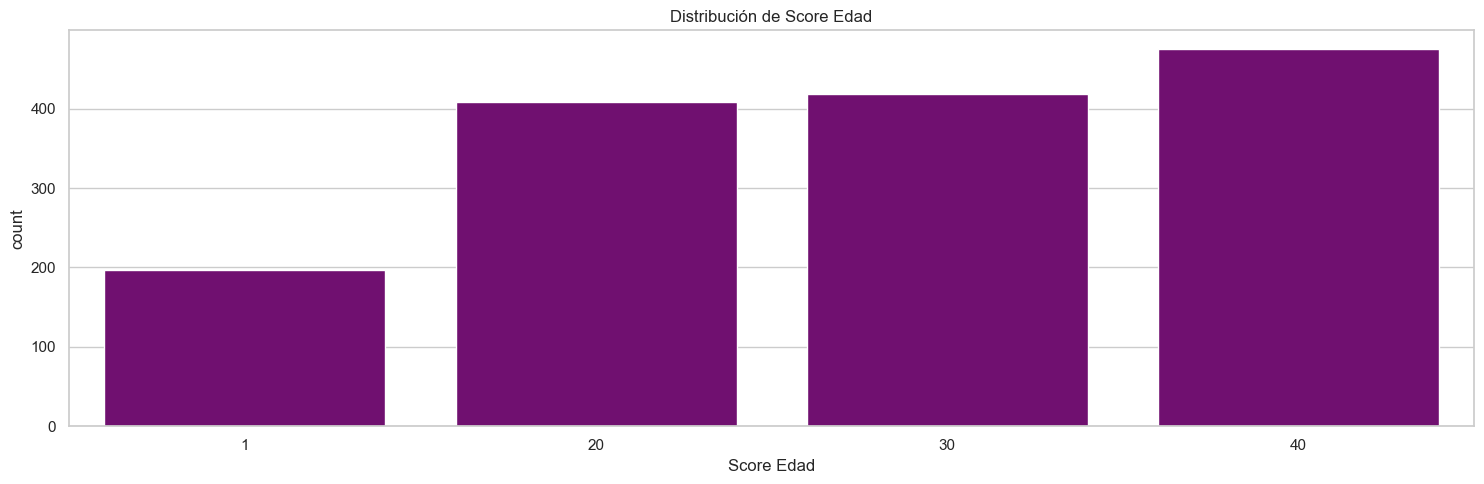


Tabla de Distribución de Frecuencias - Score Edad:
score_edad
40    475
30    419
20    409
1     197
Name: count, dtype: int64


In [99]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración opcional para mejorar el estilo del gráfico
sns.set(style="whitegrid")
plt.figure(figsize=(15, 5))

# Subgráfico: Distribución de score_edad
sns.countplot(x='score_edad', data=df_edad, color='purple')
plt.title('Distribución de Score Edad')
plt.xlabel('Score Edad')

# Ajustes de diseño
plt.tight_layout()

# Mostrar la figura
plt.show()

# Imprimir la tabla en la consola
score_edad_counts = df_edad['score_edad'].value_counts()

print("\nTabla de Distribución de Frecuencias - Score Edad:")
print(score_edad_counts)


### >>>DISCAPACIDAD.SCORE

In [63]:
def puntaje_discapacidad(grado_dis):
    if grado_dis == 0:
        return 0
    elif grado_dis == 1:
        return 10
    else:  # grado_dis == 2
        return 20

def procesar_discapacidad(df):
    # Copiar el DataFrame para evitar modificar el original
    df_discapacidad = df.copy()

    # Aplicar la función 
    df_discapacidad['score_discapacidad'] = df_discapacidad['grado_dis'].apply(puntaje_discapacidad)

    # Calcular el Min-Max Scaling 
    min_valor = df_discapacidad['score_discapacidad'].min()
    max_valor = df_discapacidad['score_discapacidad'].max()
    rango_deseado = 100
    min_deseado = 0

    df_discapacidad['score_discapacidad_scaled'] = ((df_discapacidad['score_discapacidad'] - min_valor) / (max_valor - min_valor)) * rango_deseado + min_deseado

    df_discapacidad['score_discapacidad_weighted'] = df_discapacidad['score_discapacidad_scaled'] * discapacidad_weight
    
    # Devolver el DataFrame con las columnas seleccionadas
    return df_discapacidad[['dni', 'score_discapacidad', 'score_discapacidad_scaled','score_discapacidad_weighted']].sort_values(by='dni')

# aplicar funcion
df_discapacidad = procesar_discapacidad(df)
df_discapacidad

,dni,score_discapacidad,score_discapacidad_scaled,score_discapacidad_weighted
55,10076758,20,100.0,12.50
1290,10171954,10,50.0,6.25
1192,10196231,20,100.0,12.50
608,10209961,0,0.0,0.00
348,10344303,20,100.0,12.50
...,...,...,...,...
1472,99794603,10,50.0,6.25
144,99913412,0,0.0,0.00
1286,99929175,0,0.0,0.00
24,99949389,10,50.0,6.25


d:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


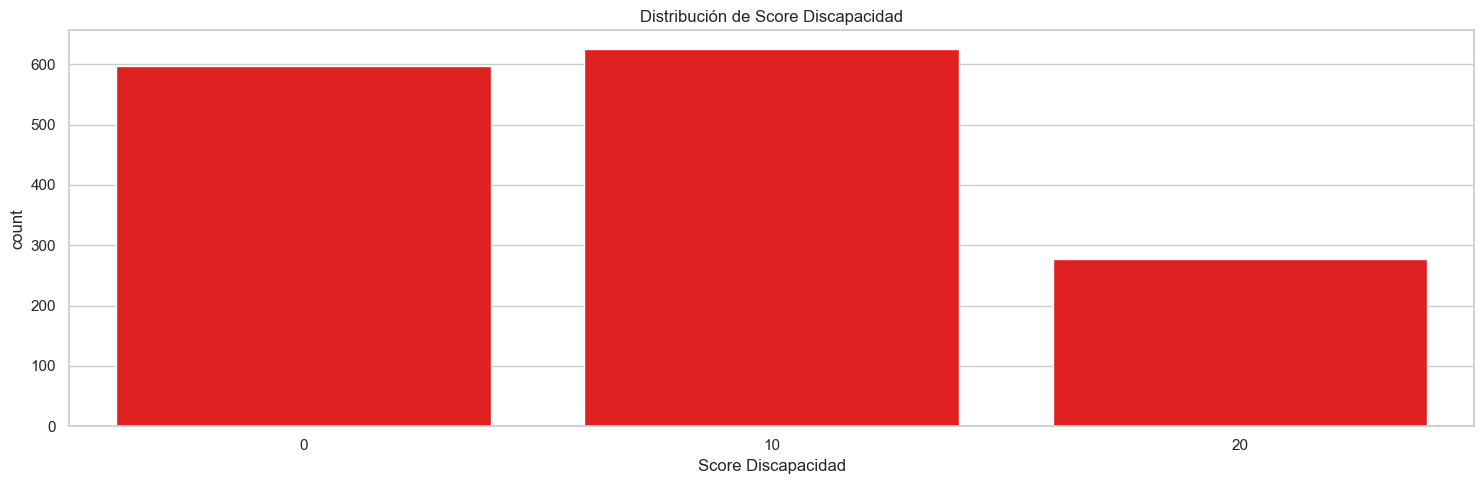


Tabla de Distribución de Frecuencias - Score Discapacidad:
score_discapacidad
10    625
0     598
20    277
Name: count, dtype: int64


In [98]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración opcional para mejorar el estilo del gráfico
sns.set(style="whitegrid")
plt.figure(figsize=(15, 5))

# Subgráfico: Distribución de score_discapacidad
sns.countplot(x='score_discapacidad', data=df_discapacidad, color='red')
plt.title('Distribución de Score Discapacidad')
plt.xlabel('Score Discapacidad')

# Ajustes de diseño
plt.tight_layout()

# Mostrar la figura
plt.show()

# Imprimir la tabla en la consola
score_discapacidad_counts = df_discapacidad['score_discapacidad'].value_counts()

print("\nTabla de Distribución de Frecuencias - Score Discapacidad:")
print(score_discapacidad_counts)


### >>>SCORE FAMILIA NUMEROSA

In [64]:
def puntaje_familia(tipo_fam_num):
    if tipo_fam_num == 0:
        return 0
    elif tipo_fam_num == 1:
        return 5
    else:  # tipo_fam_num == 2
        return 10

def procesar_familia(df):
    # Copiar el DataFrame para evitar modificar el original
    df_familia = df.copy()

    # Aplicar la función 
    df_familia['score_familia'] = df_familia['tipo_fam_num'].apply(puntaje_familia)

    # Calcular el Min-Max Scaling 
    min_valor = df_familia['score_familia'].min()
    max_valor = df_familia['score_familia'].max()
    rango_deseado = 100
    min_deseado = 0

    df_familia['score_familia_scaled'] = ((df_familia['score_familia'] - min_valor) / (max_valor - min_valor)) * rango_deseado + min_deseado

    df_familia['score_familia_weighted'] = df_familia['score_familia_scaled'] * familia_weight
    
    # Devolver el DataFrame con las columnas seleccionadas
    return df_familia[['dni', 'score_familia', 'score_familia_scaled','score_familia_weighted']].sort_values(by='dni')

# aplicar funcion
df_familia = procesar_familia(df)
df_familia

,dni,score_familia,score_familia_scaled,score_familia_weighted
55,10076758,0,0.0,0.00
1290,10171954,10,100.0,12.50
1192,10196231,10,100.0,12.50
608,10209961,5,50.0,6.25
348,10344303,5,50.0,6.25
...,...,...,...,...
1472,99794603,0,0.0,0.00
144,99913412,0,0.0,0.00
1286,99929175,10,100.0,12.50
24,99949389,0,0.0,0.00


d:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


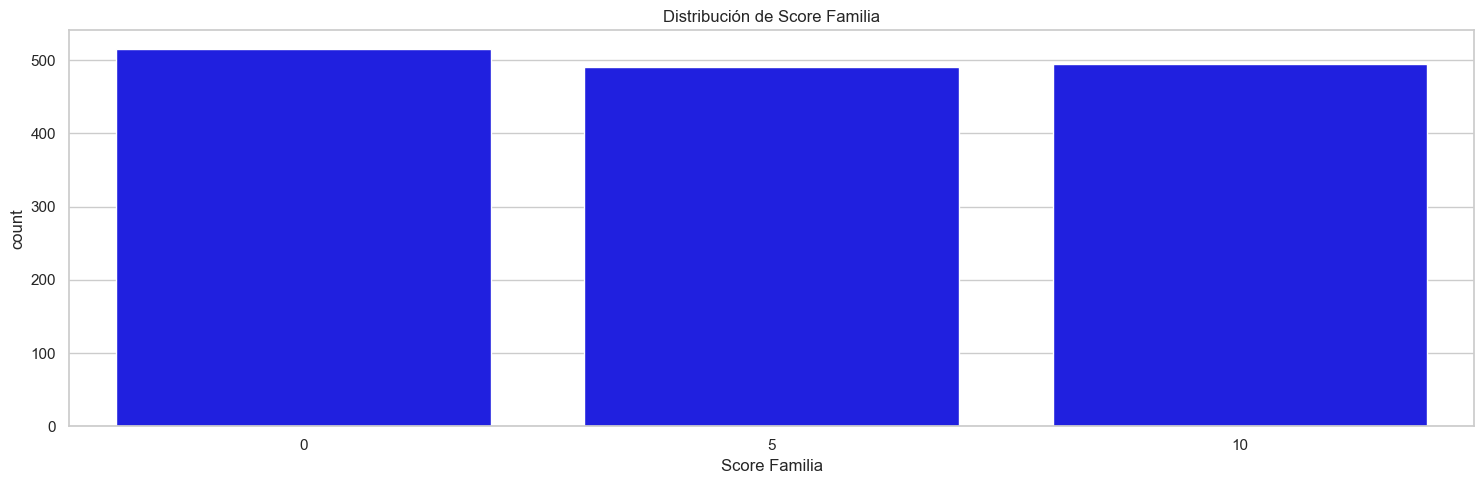


Tabla de Distribución de Frecuencias - Score Familia:
score_familia
0     515
10    495
5     490
Name: count, dtype: int64


In [97]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración opcional para mejorar el estilo del gráfico
sns.set(style="whitegrid")
plt.figure(figsize=(15, 5))

# Subgráfico: Distribución de score_familia
sns.countplot(x='score_familia', data=df_familia, color='blue')
plt.title('Distribución de Score Familia')
plt.xlabel('Score Familia')

# Ajustes de diseño
plt.tight_layout()

# Mostrar la figura
plt.show()

# Imprimir la tabla en la consola
score_familia_counts = df_familia['score_familia'].value_counts()

print("\nTabla de Distribución de Frecuencias - Score Familia:")
print(score_familia_counts)


### >>>COCHE - ARRENDADOR - OFICIO ESPECIAL

In [65]:
def puntaje_coche_arrendador(coche_arrendador_oficio):
    if coche_arrendador_oficio == True:
        return 0
    else:  #  == False
        return 100

def puntaje_oficio(coche_arrendador_oficio):
    if coche_arrendador_oficio == True:
        return 100
    else:  #  == False
        return 0


def procesar_coche_arrendador_oficio(df):
    # Copiar el DataFrame para evitar modificar el original
    df_coche_arrendador_oficio = df.copy()

    # Aplicar la función 
    df_coche_arrendador_oficio['score_coche'] = df_coche_arrendador_oficio['coche'].apply(puntaje_coche_arrendador)
    df_coche_arrendador_oficio['score_arrendador'] = df_coche_arrendador_oficio['arrendador'].apply(puntaje_coche_arrendador)
    df_coche_arrendador_oficio['score_oficio_especial'] = df_coche_arrendador_oficio['oficio_especial'].apply(puntaje_oficio)


    df_coche_arrendador_oficio['score_coche_weighted'] = df_coche_arrendador_oficio['score_coche'] * coche_wight
    df_coche_arrendador_oficio['score_arrendador_weighted'] = df_coche_arrendador_oficio['score_arrendador'] * arrendador_wight
    df_coche_arrendador_oficio['score_oficio_especial_weighted'] = df_coche_arrendador_oficio['score_oficio_especial'] * oficio_especial_wight
     
    # Devolver el DataFrame con las columnas seleccionadas
    return df_coche_arrendador_oficio[['dni', 'score_coche', 'score_coche_weighted','score_arrendador','score_arrendador_weighted','score_oficio_especial', 'score_oficio_especial_weighted','fecha_de_nacimiento','id_solicitud' ]].sort_values(by='dni')


# aplicar funcion
df_coche_arrendador_oficio = procesar_coche_arrendador_oficio(df)
df_coche_arrendador_oficio

,dni,score_coche,score_coche_weighted,score_arrendador,score_arrendador_weighted,score_oficio_especial,score_oficio_especial_weighted,fecha_de_nacimiento,id_solicitud
55,10076758,100,12.5,0,0.0,100,12.5,1914-02-13,1001
1290,10171954,100,12.5,0,0.0,0,0.0,1915-05-09,791
1192,10196231,0,0.0,0,0.0,0,0.0,1922-12-02,37351
608,10209961,0,0.0,0,0.0,100,12.5,1909-01-11,33532
348,10344303,100,12.5,0,0.0,0,0.0,1931-02-03,1487
...,...,...,...,...,...,...,...,...,...
1472,99794603,0,0.0,0,0.0,0,0.0,1921-04-24,35037
144,99913412,100,12.5,0,0.0,100,12.5,1930-08-07,547
1286,99929175,0,0.0,100,12.5,100,12.5,1932-12-17,38236
24,99949389,0,0.0,100,12.5,100,12.5,1934-11-27,51018


d:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Anaconda\Lib\site-package

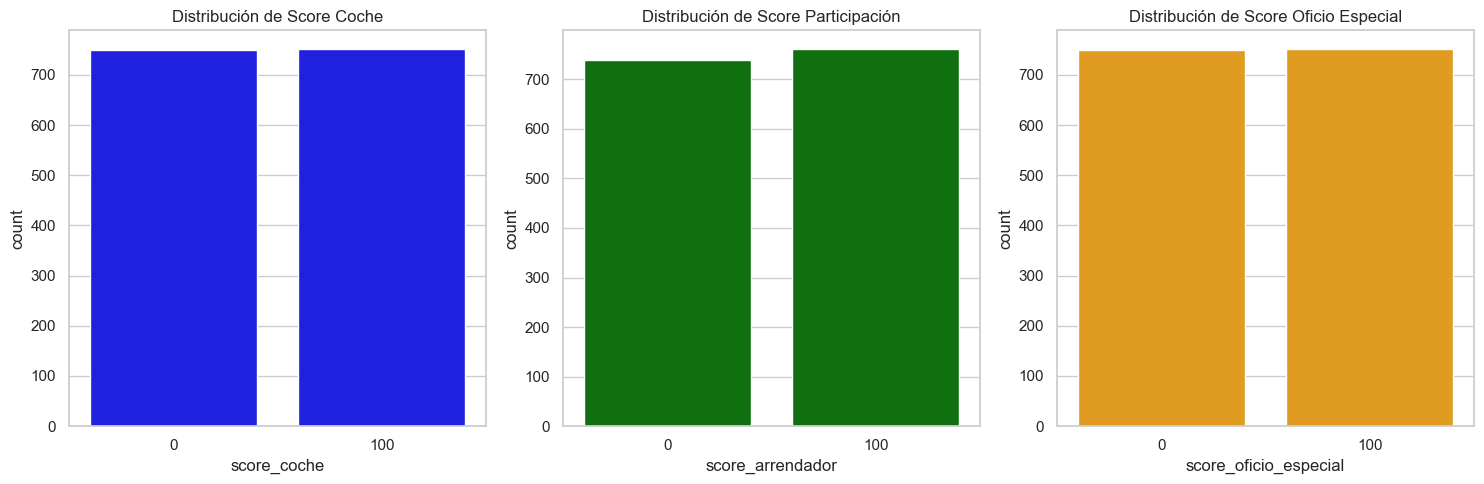


Tabla de Distribución de Frecuencias:

Score Coche:
score_coche
100    751
0      749
Name: count, dtype: int64

Score Participación:
score_arrendador
100    761
0      739
Name: count, dtype: int64

Score Oficio Especial:
score_oficio_especial
100    751
0      749
Name: count, dtype: int64


In [94]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración opcional para mejorar el estilo del gráfico
sns.set(style="whitegrid")
plt.figure(figsize=(15, 5))

# Subgráficos
plt.subplot(1, 3, 1)
sns.countplot(x='score_coche', data=df_coche_arrendador_oficio, color='blue')
plt.title('Distribución de Score Coche')

plt.subplot(1, 3, 2)
sns.countplot(x='score_arrendador', data=df_coche_arrendador_oficio, color='green')
plt.title('Distribución de Score Participación')

plt.subplot(1, 3, 3)
sns.countplot(x='score_oficio_especial', data=df_coche_arrendador_oficio, color='orange')
plt.title('Distribución de Score Oficio Especial')

# Ajustes de diseño
plt.tight_layout()

# Mostrar la figura
plt.show()

# Imprimir la tabla en la consola
score_coche_counts = df_coche_arrendador_oficio['score_coche'].value_counts()
score_arrendador_counts = df_coche_arrendador_oficio['score_arrendador'].value_counts()
score_oficio_especial_counts = df_coche_arrendador_oficio['score_oficio_especial'].value_counts()

print("\nTabla de Distribución de Frecuencias:")
print("\nScore Coche:")
print(score_coche_counts)
print("\nScore Participación:")
print(score_arrendador_counts)
print("\nScore Oficio Especial:")
print(score_oficio_especial_counts)



### >>>PARTICIPACION PREVIA

In [66]:
def participacion_previa(resultado_t_1, suma_viajes_t_1y_t_2, viajes_t_1, viajes_t_2):
    if resultado_t_1 == 2:
        return 175
    elif suma_viajes_t_1y_t_2 == 0:
        return 50
    elif viajes_t_1 == 0 and viajes_t_2 > 0:
        return 40
    elif viajes_t_1 > 0 and viajes_t_2 == 0:
        return 20
    elif suma_viajes_t_1y_t_2 >= 3:
            return 0
    else:
        return 10

def procesar_participacion_previa(df):
    # Copiar el DataFrame para evitar modificar el original
    df_participacion_previa = df.copy()

    # Aplicar la función
    df_participacion_previa['score_participacion_previa'] = df_participacion_previa.apply(
    lambda row: participacion_previa(
        row['resultado_solicitud_t_1'],
        row['suma_viajes_t_1_y_t_2'],
        row['viajes_t_1'],
        row['viajes_t_2']
    ),
    axis=1
    
    
    
)
    # Calcular el Min-Max Scaling 
    min_valor = df_participacion_previa['score_participacion_previa'].min()
    max_valor = df_participacion_previa['score_participacion_previa'].max()
    rango_deseado = 100
    min_deseado = 0

    df_participacion_previa['score_participacion_previa_scaled'] = (
        (df_participacion_previa['score_participacion_previa'] - min_valor) / (max_valor - min_valor)
    ) * rango_deseado + min_deseado

    df_participacion_previa['score_participacion_previa_weighted'] = (
        df_participacion_previa['score_participacion_previa_scaled'] * participacion_previa_weight
    )
    
    # Devolver el DataFrame con las columnas seleccionadas
    return df_participacion_previa[[
        'dni', 
        'score_participacion_previa', 
        'score_participacion_previa_scaled',
        'score_participacion_previa_weighted'
    ]].sort_values(by='score_participacion_previa_weighted')

# Aplicar la función
df_participacion_previa = procesar_participacion_previa(df)
df_participacion_previa



,dni,score_participacion_previa,score_participacion_previa_scaled,score_participacion_previa_weighted
615,61926331,0,0.0,0.0
464,70867592,0,0.0,0.0
1125,69375757,0,0.0,0.0
1126,23484199,0,0.0,0.0
1131,90664728,0,0.0,0.0
...,...,...,...,...
330,79583757,175,100.0,12.5
1016,24032377,175,100.0,12.5
331,76906611,175,100.0,12.5
1012,87915846,175,100.0,12.5


d:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


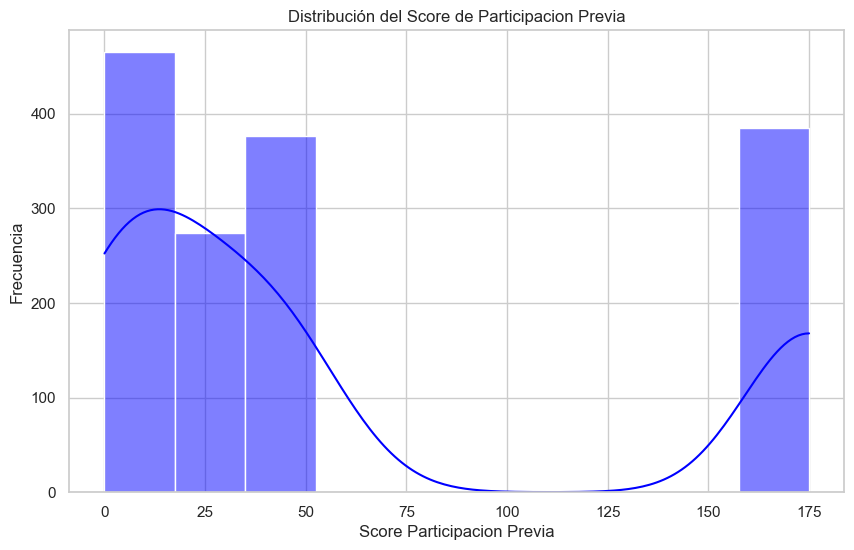

            Rango  Frecuencia
0   (-0.18, 17.5]         465
1    (17.5, 35.0]         274
2    (35.0, 52.5]         376
3    (52.5, 70.0]           0
4    (70.0, 87.5]           0
5   (87.5, 105.0]           0
6  (105.0, 122.5]           0
7  (122.5, 140.0]           0
8  (140.0, 157.5]           0
9  (157.5, 175.0]         385


C:\Users\DELL\AppData\Local\Temp\ipykernel_26888\2290768704.py:22: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tabla_frecuencia = pd.value_counts(intervalos).sort_index().reset_index()


In [72]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Configuración opcional para mejorar el estilo del gráfico
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Crear el histograma
sns.histplot(df_participacion_previa['score_participacion_previa'], bins=10, kde=True, color='blue')

# Agregar etiquetas y título
plt.xlabel('Score Participacion Previa')
plt.ylabel('Frecuencia')
plt.title('Distribución del Score de Participacion Previa')

# Mostrar el histograma
plt.show()

# Crear intervalos y contar la frecuencia
intervalos = pd.cut(df_participacion_previa['score_participacion_previa'], bins=10, precision=2)
tabla_frecuencia = pd.value_counts(intervalos).sort_index().reset_index()
tabla_frecuencia.columns = ['Rango', 'Frecuencia']

# Mostrar la tabla
print(tabla_frecuencia)


### >>>MERGE 

In [68]:
#Merge de dataframes
score_merged = pd.merge(df_edad, df_discapacidad, on='dni', how='inner')\
              .merge(df_coche_arrendador_oficio, on='dni', how='inner')\
              .merge(df_participacion_previa, on='dni', how='inner')\
              .merge(df_familia, on='dni', how='inner')


# seleccion de columnas que terminan en '_weighted'
columnas_weighted = [col for col in score_merged.columns if col.endswith('_weighted')]

# Crea la nueva columna 'score_total' sumando todas las columnas '_weighted'
score_merged['score_total'] = score_merged[columnas_weighted].sum(axis=1)
score_merged = score_merged.sort_values(by='score_total', ascending=False)



#Seleccion de variables weighted y otras
score_merged_weighted = score_merged.loc[:, [
                                            'id_solicitud' ,
                                            'score_total',
                                            'score_edad_weighted',
                                            'score_discapacidad_weighted',
                                            'score_coche_weighted',
                                            'score_arrendador_weighted',
                                            'score_oficio_especial_weighted',
                                            'score_familia_weighted',
                                            'score_participacion_previa_weighted']]



score_merged_weighted_rename = {

    'id_solicitud': 'id_solicitud',
    'score_total': 'score',
    'score_edad_weighted': 'edad_score',
    'score_discapacidad_weighted': 'discapacidad_score',
    'score_coche_weighted': 'coche_score',
    'score_arrendador_weighted': 'arrendador_score',
    'score_oficio_especial_weighted': 'oficio_especial_score',
    'score_participacion_previa_weighted': 'participacion_previa_score',
    'score_familia_weighted': 'familia_score'
    
}

# Renombrar todas las columnas
score_merged_weighted = score_merged_weighted.rename(columns=score_merged_weighted_rename)


score_merged_weighted

,id_solicitud,score,edad_score,discapacidad_score,coche_score,arrendador_score,oficio_especial_score,familia_score,participacion_previa_score
1334,907,84.294872,9.294872,12.50,12.5,12.5,12.5,12.50,12.500000
1331,788,81.250000,12.500000,6.25,12.5,12.5,12.5,12.50,12.500000
742,905,81.250000,12.500000,12.50,12.5,12.5,12.5,6.25,12.500000
1411,745,81.250000,12.500000,6.25,12.5,12.5,12.5,12.50,12.500000
567,1372,81.089744,6.089744,12.50,12.5,12.5,12.5,12.50,12.500000
...,...,...,...,...,...,...,...,...,...
171,34412,2.857143,0.000000,0.00,0.0,0.0,0.0,0.00,2.857143
1096,14,1.428571,0.000000,0.00,0.0,0.0,0.0,0.00,1.428571
110,1375,0.000000,0.000000,0.00,0.0,0.0,0.0,0.00,0.000000
431,44650,0.000000,0.000000,0.00,0.0,0.0,0.0,0.00,0.000000


### >>>EVALUACION DEL MODELO

In [69]:
score_merged_weighted.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1500 entries, 1334 to 610
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id_solicitud                1500 non-null   int64  
 1   score                       1500 non-null   float64
 2   edad_score                  1500 non-null   float64
 3   discapacidad_score          1500 non-null   float64
 4   coche_score                 1500 non-null   float64
 5   arrendador_score            1500 non-null   float64
 6   oficio_especial_score       1500 non-null   float64
 7   familia_score               1500 non-null   float64
 8   participacion_previa_score  1500 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 117.2 KB


  Score Range  Número de Usuarios  Porcentaje
3        0-20                  80    5.333333
1       21-40                 543   36.200000
0       41-60                 716   47.733333
2       61-80                 152   10.133333
4      81-100                   6    0.400000


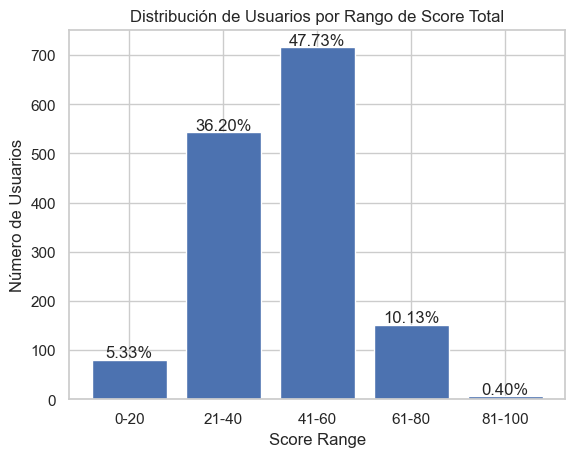

In [70]:
import pandas as pd
import matplotlib.pyplot as plt

# Crear rangos para los puntajes
bins = [0, 20, 40, 60, 80, 100]
labels = ['0-20', '21-40', '41-60', '61-80', '81-100']

# Agregar una nueva columna 'score_range' al DataFrame
score_merged_weighted['score_range'] = pd.cut(score_merged_weighted['score'], bins=bins, labels=labels)

# Contar usuarios por rango de score
usuarios_por_rango = score_merged_weighted['score_range'].value_counts().reset_index()

# Renombrar las columnas
usuarios_por_rango.columns = ['Score Range', 'Número de Usuarios']

# Calcular el porcentaje de usuarios en cada rango
total_usuarios = len(score_merged_weighted)
usuarios_por_rango['Porcentaje'] = (usuarios_por_rango['Número de Usuarios'] / total_usuarios) * 100

# Ordenar por 'Score Range'
usuarios_por_rango = usuarios_por_rango.sort_values('Score Range')

# Mostrar la tabla
print(usuarios_por_rango)

# Gráfico de barras para visualizar la distribución
plt.bar(usuarios_por_rango['Score Range'], usuarios_por_rango['Número de Usuarios'])
plt.title('Distribución de Usuarios por Rango de Score Total')
plt.xlabel('Score Range')
plt.ylabel('Número de Usuarios')

# Agregar porcentajes en el gráfico
for i, porcentaje in enumerate(usuarios_por_rango['Porcentaje']):
    plt.text(i, usuarios_por_rango['Número de Usuarios'].iloc[i] + 5, f'{porcentaje:.2f}%', ha='center')

plt.show()
